# CS 5324 Lab 5: Wide and Deep Networks

For this assignment, we will be exploring the [Heart Failure Prediction](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction?resource=download) dataset. It is a collection of datasets combined into one large dataset. This dataset is composed of observations regarding patients' health traits related to the likelihood of heart failure.

This dataset was sourced from [Kaggle](https://www.kaggle.com/datasets) and consists of 918 observations.

## Team

The team consists of three members:
1. Melodie Zhu
2. Samina Faheem
3. Giancarlos Dominguez

## Dataset Preparation

Let us import our dataset.

In [1]:
# import libraies
import os
import pandas as pd
import numpy as np
import copy

In [2]:
# get dataset from csv file
data_directory = os.getcwd() + '\\data\\heart.csv'
df = pd.read_csv(data_directory)

In [3]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
print("Shape of the dataset", df.shape)

print(f"\nNumber of observations in the dataset: {df.shape[0]}")
print(f"Number of features in the dataset: {df.shape[1]}")

Shape of the dataset (918, 12)

Number of observations in the dataset: 918
Number of features in the dataset: 12


Next, we will check for any duplicate observations.

In [5]:
# check for duplicates
print(f"\nNumber of duplicate rows: {df.duplicated().sum()}")


Number of duplicate rows: 0


Luckily, we don't have to worry about duplicate rows. Now, let us check for rows with missing values.

In [6]:
# check for missing values
print(f"\nNumber of missing values: {df.isnull().sum().sum()}")


Number of missing values: 0


None of our observations have missing values. Therefore, we don't have to worry about holes in our data.

### Defining Class Variables

| Variable Name | Datatype | Description | Values |
:------: | :------: | :------: | :------:|
| `Age` | Numerical int | How old the patient is (yrs) | NA |
| `Sex` | Categorical str | The biological gender of the patient | **M**: Male, **F**: Female |
| `ChestPainType` | Categorical str | The chest pain condition of the patient | **TA**: Typical Angina, **ATA**: Atypical Angina, **NAP**: Non-Anginal Pain, **ASY**: Asymptomatic |
| `RestingBP` | Numerical int | The resting blood pressure (mmHg) | NA |
| `Cholesterol` | Numerical int | The cholesterol level of the patient (mm/dl) | NA |
| `FastingBS` | Categorical int | The fasting blood sugar level of the patient | **1**: if FastingBS > 120 (mg/dl), **0**: otherwise |
| `RestingECG` | Categorical str | The resting electrocardiogram results of the patient | **Normal**: Normal, **ST**: Having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), **LVH**: Showing probable or definite left ventricular hypertrophy by Estes' criteria |
| `MaxHR` | Numerical int | The maximum heart rate recorded in the patient | NA |
| `ExerciseAngina` | Categorical str | Whether the patient has exersice-induced angina | **Y**: Yes, **N**: No |
| `OldPeak` | Numerical float | ST segment value of the patient | NA |
| `ST_Slope` | Categorical str | Slope of the peak exercise ST segment | **Up**: Upsloping, **Flat**: Flat, **Down**: Downsloping |
| `HeartDisease` | Categorical int | Whether the patient is likely to have heart failure| **1**: Likely to have heart failure, **0**: Not likely to have heart failure

Since all of our features are medically related to heart conditions and failure, we will not remove any features from our dataset.<br>

Now, we will convert our categorical variables into integers and standardize our numerical variables.

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

df_imputed = copy.deepcopy(df)

# define vars to encode as integer    
encoders = dict()
categorical_headers = [
    'Sex',
    'ChestPainType',
    'RestingECG',
    'ExerciseAngina',
    'ST_Slope'
]

# train all encoders
for col in categorical_headers:
    df_imputed[col] = df_imputed[col].str.strip()
    
    if col == 'HeartDisease':
        tmp = LabelEncoder()
        df_imputed[col] = tmp.fit_transform(df_imputed[col])
    else:
        # integer encode strings that are features
        encoders[col] = LabelEncoder() # save the encoder
        df_imputed[col+'_int'] = encoders[col].fit_transform(df_imputed[col])

# scale numeric, continuous variables
numeric_headers = [
    "Age", 
    "RestingBP", 
    "Cholesterol",
    "MaxHR"
]

ss = StandardScaler()
df_imputed[numeric_headers] = ss.fit_transform(df_imputed[numeric_headers])

include_header =["FastingBS","Oldpeak"]
df_imputed.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Sex_int,ChestPainType_int,RestingECG_int,ExerciseAngina_int,ST_Slope_int
0,-1.433140,M,ATA,0.410909,0.825070,0,Normal,1.382928,N,0.0,Up,0,1,1,1,0,2
1,-0.478484,F,NAP,1.491752,-0.171961,0,Normal,0.754157,N,1.0,Flat,1,0,2,1,0,1
2,-1.751359,M,ATA,-0.129513,0.770188,0,ST,-1.525138,N,0.0,Up,0,1,1,2,0,2
3,-0.584556,F,ASY,0.302825,0.139040,0,Normal,-1.132156,Y,1.5,Flat,1,0,0,1,1,1
4,0.051881,M,NAP,0.951331,-0.034755,0,Normal,-0.581981,N,0.0,Up,0,1,2,1,0,2


It should be noted that we encoded our categorical variables into integers. The column names will be denoted by their original name with "_int" added at the end, but their context to the dataset will not change. Below are the variables we will use throughout the lab.

In [8]:
categorical_headers_ints = [x+'_int' for x in categorical_headers]
feature_columns = categorical_headers_ints+numeric_headers+include_header

import pprint
pp = pprint.PrettyPrinter(indent=4)

print(f"We will use the following {len(feature_columns)} features:")
pp.pprint(feature_columns)

We will use the following 11 features:
[   'Sex_int',
    'ChestPainType_int',
    'RestingECG_int',
    'ExerciseAngina_int',
    'ST_Slope_int',
    'Age',
    'RestingBP',
    'Cholesterol',
    'MaxHR',
    'FastingBS',
    'Oldpeak']


In [9]:
print("\nCategorical String Headers:")
pp.pprint(categorical_headers) # string data
print("\nCategorical Headers, Encoded as Integer:")
pp.pprint(categorical_headers_ints) # string data encoded as an integer


Categorical String Headers:
['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

Categorical Headers, Encoded as Integer:
[   'Sex_int',
    'ChestPainType_int',
    'RestingECG_int',
    'ExerciseAngina_int',
    'ST_Slope_int']


### Cross Product Features

Our dataset has 12 features, but we will focus on the categorical features (excluding our target feature) to make 2 cross-product features. We will limit ourselves to 2 cross-product features since we don't want to overfit the model and negatively affect our model's performance.

`ChestPainType` & `ExerciseAngina`: The `ChestPainType` features considers differents types of angina. By merging the `ChestPainType` and `ExerciseAngina`, we can explore if there is any correlation between the different angina types and whether they were caused by exercise.

`FastingBS` & `RestingECG`: The changes in a patient's fasting blood sugar level can influence the heart's electrical activity. By combining these features, we hope to highlight any correlation between a patient's fasting blood sugar level and their electrocardiogram results.

### Evaluation Method

For evaluating our models' performance, we will not be using accuracy, since it is prone to being skewed depending on how balanced the dataset is, among other factors. Instead, we will be using the recall evalutuation method. We will use this method due to the medical nature of our dataset, making it necessary to account for true positives and false negatives. Predicting false negative have higher consequences in a medical dataset. Hence, Recall should be used instead of accuracy due to the importance of false negatives for this dataset.

### Dataset Splitting Method

For this dataset, we will split it using the stratified 10-fold cross validation. Since we only have 918 observations, we need to maximize the use of our dataset. This method will also ensure that the subsets are as evenly distributed like the class ratio of the overall dataset. By using stratified 10-folds, we ensure that the sub-datasets will not be more unbalanced.

In [10]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, cross_val_score

# we want to predict the X and y data as follows:
X = df_imputed[feature_columns].to_numpy()
y = df_imputed['HeartDisease'].values

# get size of dataset, number of features, and number of classes
n_samples, n_features = X.shape
n_classes = len(np.unique(y))

print("Number of observations in dataset: {}".format(n_samples))
print("Number of features in dataset: {}".format(n_features))
print("Number of classes for the target feature (HeartDisease): {}".format(n_classes))

Number of observations in dataset: 918
Number of features in dataset: 11
Number of classes for the target feature (HeartDisease): 2


Number of instances in each class:[410 508]


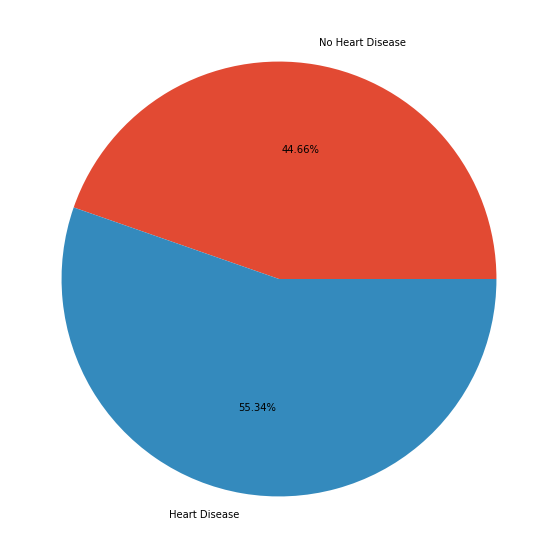

In [11]:
import matplotlib.pyplot as plt

get_ipython().run_line_magic('matplotlib', 'inline')
plt.style.use('ggplot')

print('Number of instances in each class:'+str(np.bincount(y)))

# plot piechart of the number of instances in each class
plt.figure(figsize=(15,10))
plt.pie(np.bincount(y), labels=['No Heart Disease', 'Heart Disease'], autopct='%1.2f%%')
plt.show()

From the pie chart above, we observe that the dataset classes are unbalanced. There are more patients with the likelihood of having heart failure than those not likely to have heart disease. With stratified 10-fold cross validation, all of our subsets will have the same 55/44 class ratio to prevent it from becoming further unbalanced.

Now, we will split our dataset.

In [12]:
num_cv_iterations = 10
num_instances = len(y)
cv_object = StratifiedKFold(n_splits=num_cv_iterations)
                         
print(cv_object)

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)


In [13]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.models import Model
from sklearn import metrics as mt

iter_num=0

for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]


Recall score average: 87.25490196078432


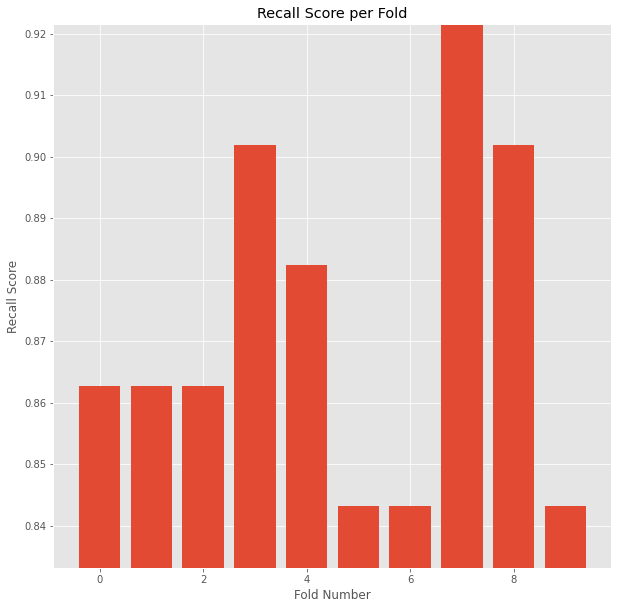

In [14]:
from sklearn.metrics import make_scorer, recall_score
from sklearn.linear_model import LogisticRegression

# select model
clf = LogisticRegression()
clf.fit(X,y)

#select cross validation
cv = StratifiedShuffleSplit(n_splits=10)
# select evaluation criteria
my_scorer = make_scorer(recall_score)

# run model training and cross validation
per_fold_eval_criteria = cross_val_score(estimator=clf,
                                    X=X,
                                    y=y,
                                    cv=cv,
                                    scoring=my_scorer
                                   )

plt.figure(figsize=(10,10))
plt.bar(range(len(per_fold_eval_criteria)),per_fold_eval_criteria)
plt.ylim([min(per_fold_eval_criteria)-0.01,max(per_fold_eval_criteria)])

# title and labels
plt.title('Recall Score per Fold')
plt.ylabel('Recall Score')
plt.xlabel('Fold Number')

print(f'Recall score average: {per_fold_eval_criteria.mean()*100}')
plt.show()

Some of our folds have a recall value of 0.9. The closer to 1 the recall score is, the better our model's performance. Since our average recall value among the folds is in the high 0.8's, we can say that our model is performing well.

## Modeling

We will create five different wide and deep networks. The first three will consist of different cross-product features combinations.

From these three models, we will choose the cross-product feature combination from the model that performed best and use it as input to the last two wide and deep neural networks, which will have a number of layers.

Lastly, we will compare our best performing model from the five models to a deep network (without the wide branch.)

### First Combination

In [15]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import concatenate
import tensorflow as tf

embed_branches = []
all_branch_outputs = [] # this is where we will keep track of output of each branch

# feed in the entire matrix of categircal variables
input_branch = Input(shape=(X_train.shape[1],), 
                     dtype='int64', 
                     name='categorical')

# for each categorical variable
for idx,col in enumerate(categorical_headers_ints):
    
    # what the maximum integer value for this variable?
    # which is the same as the number of categories
    N = df_imputed[col].max()+1 
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_branch, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs in list to concatenate later
    all_branch_outputs.append(x)
    
# now concatenate the outputs and add a fully connected layer
final_branch = concatenate(all_branch_outputs, name='concat_1')
final_branch = Dense(units=1,
                     activation='sigmoid', 
                     name='combined')(final_branch)

In [16]:
cat_X = df_imputed[categorical_headers_ints].to_numpy()
# we want to predict the X and y data as follows:
cat_y = df_imputed['HeartDisease'].values # get the labels we want
iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(cat_X,cat_y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train_cat = cat_X[train_indices]
    y_train_cat = cat_y[train_indices]
    
    X_test_cat = cat_X[test_indices]
    y_test_cat = cat_y[test_indices]
    
num_X = df_imputed[categorical_headers_ints].to_numpy()
# we want to predict the X and y data as follows:
num_y = df_imputed['HeartDisease'].values # get the labels we want
iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(num_X,num_y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train_num = num_X[train_indices]
    y_train_num = num_y[train_indices]
    
    X_test_num = num_X[test_indices]
    y_test_num = num_y[test_indices]

In [17]:
all_branch_outputs = [] # this is where we will keep track of output of each branch

input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical')
for idx,col in enumerate(categorical_headers_ints):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = df_imputed[col].max()+1
    
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_cat, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    all_branch_outputs.append(x)
    
# HERE IS THE ADDING OF AN INPUT USING NUMERIC DATA
# create dense input branch for numeric
inputs_num = Input(shape=(X_train_num.shape[1],), name='numeric')
x_dense = Dense(units=22, activation='relu', name='num_1')(inputs_num)
    
all_branch_outputs.append(x_dense)

# now concatenate the outputs and add a fully connected layer
final_branch = concatenate(all_branch_outputs, name='concat_1')
final_branch = Dense(units=10, activation='relu', name='combined_1')(final_branch)
final_branch = Dense(units=1, activation='sigmoid', name='combined_2')(final_branch)

In [18]:
for col in categorical_headers:
    vals = df_imputed[col].unique()
    print(col,'has', len(vals), 'unique values:')
    print(vals)

Sex has 2 unique values:
['M' 'F']
ChestPainType has 4 unique values:
['ATA' 'NAP' 'ASY' 'TA']
RestingECG has 3 unique values:
['Normal' 'ST' 'LVH']
ExerciseAngina has 2 unique values:
['N' 'Y']
ST_Slope has 3 unique values:
['Up' 'Flat' 'Down']


In [19]:
cross_columns = [['ST_Slope','RestingECG'],['ChestPainType','RestingECG']]
# cross each set of columns in the list above
cross_col_df_names = []
for cols_list in cross_columns:
    # encode as ints for the embedding
    enc = LabelEncoder()
    
    # 1. create crossed labels by join operation
    X_crossed_train = df_imputed[cols_list].apply(lambda x: '_'.join(x), axis=1)
   # X_crossed_test = df_test[cols_list].apply(lambda x: '_'.join(x), axis=1)
    
    # get a nice name for this new crossed column
    cross_col_name = '_'.join(cols_list)
    
    # 2. encode as integers
    enc.fit(np.hstack((X_crossed_train.to_numpy())))
    
    # 3. Save into dataframe with new name
    df_imputed[cross_col_name] = enc.transform(X_crossed_train)
    #df_test[cross_col_name] = enc.transform(X_crossed_test)
    
    # keep track of the new names of the crossed columns
    cross_col_df_names.append(cross_col_name) 

In [20]:
cross_X = df_imputed[cross_col_df_names].to_numpy()
# we want to predict the X and y data as follows:
cross_y = df_imputed['HeartDisease'].values # get the labels we want
iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(cross_X,cross_y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train_crossed = cross_X[train_indices]
    y_train_crossed = cross_y[train_indices]
    
    X_test_crossed = cross_X[test_indices]
    y_test_crossed = cross_y[test_indices]

In [21]:
crossed_outputs = []

# CROSSED DATA INPUT
input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
for idx,col in enumerate(cross_col_df_names):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = df_imputed[col].max()+1
    
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_crossed, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    crossed_outputs.append(x)
    

# now concatenate the outputs and add a fully connected layer
wide_branch = concatenate(crossed_outputs, name='wide_concat')

# reset this input branch
all_deep_branch_outputs = []

# CATEGORICAL DATA INPUT
input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
for idx,col in enumerate(categorical_headers_ints):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = df_imputed[col].max()+1
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_cat, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    all_deep_branch_outputs.append(x)
    
# NUMERIC DATA INPUT
# create dense input branch for numeric
input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
x_dense = Dense(units=22, activation='relu',name='num_1')(input_num)
    
all_deep_branch_outputs.append(x_dense)


# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    
# merge the deep and wide branch
final_branch = concatenate([wide_branch, deep_branch],
                           name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

model = Model(inputs=[input_crossed,input_cat,input_num], 
              outputs=final_branch)

In [22]:
# import plot_model
from tensorflow.keras.utils import plot_model 

plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

model.summary()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 categorical_input (InputLayer)  [(None, 5)]         0           []                               
                                                                                                  
 tf.compat.v1.gather_12 (TFOpLa  (None,)             0           ['categorical_input[0][0]']      
 mbda)                                                                                            
                                                                                                  
 tf.compat.v1.gather_13 (TFOpLa  (None,)             0           ['categorical_input[0][0]']      
 mbda)                                      

In [23]:
from tensorflow.keras.metrics import Recall
from tensorflow.keras.metrics import AUC

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[Recall(),AUC(from_logits=True)])

history1 = model.fit([X_train_crossed,X_train_cat,X_train_num],
                    y_train, 
                    epochs=15, 
                    batch_size=32, 
                    verbose=1, 
                    validation_data = ([X_test_crossed,X_test_cat,X_test_num],y_test))

Epoch 1/15
26/26 [==============================] - 3s 21ms/step - loss: 0.2351 - recall: 0.9934 - auc: 0.7792 - val_loss: 0.2287 - val_recall: 0.9000 - val_auc: 0.8312
Epoch 2/15
26/26 [==============================] - 0s 4ms/step - loss: 0.1995 - recall: 0.9127 - auc: 0.8813 - val_loss: 0.1874 - val_recall: 0.8200 - val_auc: 0.8507
Epoch 3/15
26/26 [==============================] - 0s 4ms/step - loss: 0.1395 - recall: 0.8799 - auc: 0.8988 - val_loss: 0.1560 - val_recall: 0.7400 - val_auc: 0.8624
Epoch 4/15
26/26 [==============================] - 0s 4ms/step - loss: 0.1155 - recall: 0.8734 - auc: 0.9067 - val_loss: 0.1506 - val_recall: 0.7400 - val_auc: 0.8659
Epoch 5/15
26/26 [==============================] - 0s 4ms/step - loss: 0.1117 - recall: 0.8690 - auc: 0.9102 - val_loss: 0.1429 - val_recall: 0.8200 - val_auc: 0.8620
Epoch 6/15
26/26 [==============================] - 0s 5ms/step - loss: 0.1103 - recall: 0.8690 - auc: 0.9125 - val_loss: 0.1452 - val_recall: 0.7600 - val_auc

3/3 [==============================] - 0s 4ms/step


<Axes: >

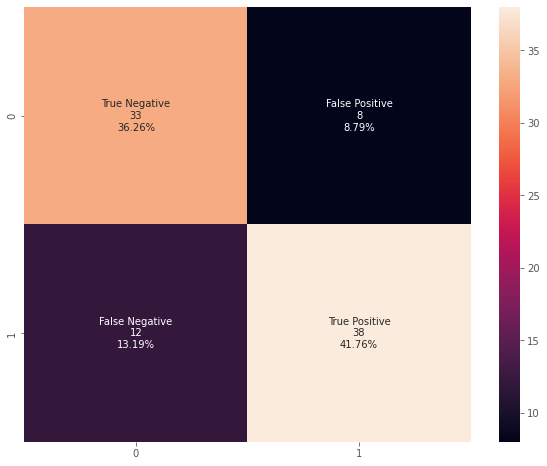

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

yhat1 = np.round(model.predict([X_test_crossed,X_test_cat,X_test_num]))

# create confusion matrix
cf_matrix = confusion_matrix(y_test, yhat1)

# create number of values in each group
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

# create percentages of each group
group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]

# create labels
group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(10,8))
sns.heatmap(cf_matrix, annot=labels, fmt='')

In [25]:
hist1Keys = list(history1.history.keys())
print(hist1Keys)

['loss', 'recall', 'auc', 'val_loss', 'val_recall', 'val_auc']


Text(0.5, 0, 'epochs')

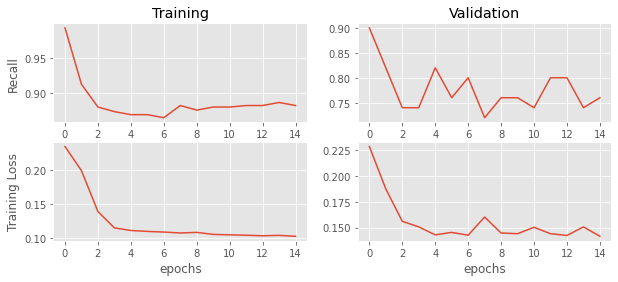

In [26]:
get_ipython().run_line_magic('matplotlib', 'inline')

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history1.history[hist1Keys[1]])

plt.ylabel('Recall')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history1.history[hist1Keys[4]])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history1.history[hist1Keys[0]])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history1.history[hist1Keys[3]])
plt.xlabel('epochs')


In [27]:
print(mt.classification_report(y_test,yhat1))
print("Model Accuracy: ",mt.accuracy_score(y_test,yhat1))

              precision    recall  f1-score   support

           0       0.73      0.80      0.77        41
           1       0.83      0.76      0.79        50

    accuracy                           0.78        91
   macro avg       0.78      0.78      0.78        91
weighted avg       0.78      0.78      0.78        91

Model Accuracy:  0.7802197802197802


### Second Combination

In [28]:
cross_columns = [['ChestPainType','RestingECG'],
                ['Sex','ExerciseAngina','ST_Slope']]

# cross each set of columns in the list above
cross_col_df_names = []
for cols_list in cross_columns:
    # encode as ints for the embedding
    enc = LabelEncoder()
    
    # 1. create crossed labels by join operation
    X_crossed_train = df_imputed[cols_list].apply(lambda x: '_'.join(x), axis=1)
   # X_crossed_test = df_test[cols_list].apply(lambda x: '_'.join(x), axis=1)
    
    # get a nice name for this new crossed column
    cross_col_name = '_'.join(cols_list)
    
    # 2. encode as integers
    enc.fit(np.hstack((X_crossed_train.to_numpy())))
    
    # 3. Save into dataframe with new name
    df_imputed[cross_col_name] = enc.transform(X_crossed_train)
    #df_test[cross_col_name] = enc.transform(X_crossed_test)
    
    # keep track of the new names of the crossed columns
    cross_col_df_names.append(cross_col_name) 

In [29]:
cross_X = df_imputed[cross_col_df_names].to_numpy()
# we want to predict the X and y data as follows:
cross_y = df_imputed['HeartDisease'].values # get the labels we want
iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(cross_X,cross_y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train_crossed = cross_X[train_indices]
    y_train_crossed = cross_y[train_indices]
    
    X_test_crossed = cross_X[test_indices]
    y_test_crossed = cross_y[test_indices]

In [30]:
crossed_outputs = []

# CROSSED DATA INPUT
input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
for idx,col in enumerate(cross_col_df_names):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = df_imputed[col].max()+1
    
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_crossed, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    crossed_outputs.append(x)

# now concatenate the outputs and add a fully connected layer
wide_branch = concatenate(crossed_outputs, name='wide_concat')

# reset this input branch
all_deep_branch_outputs = []

# CATEGORICAL DATA INPUT
input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
for idx,col in enumerate(categorical_headers_ints):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = df_imputed[col].max()+1
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_cat, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    all_deep_branch_outputs.append(x)
    
# NUMERIC DATA INPUT
# create dense input branch for numeric
input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
x_dense = Dense(units=22, activation='relu',name='num_1')(input_num)
    
all_deep_branch_outputs.append(x_dense)


# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    
# merge the deep and wide branch
final_branch = concatenate([wide_branch, deep_branch],
                           name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

model = Model(inputs=[input_crossed,input_cat,input_num], 
              outputs=final_branch)

In [31]:
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

model.summary()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 categorical_input (InputLayer)  [(None, 5)]         0           []                               
                                                                                                  
 tf.compat.v1.gather_19 (TFOpLa  (None,)             0           ['categorical_input[0][0]']      
 mbda)                                                                                            
                                                                                                  
 tf.compat.v1.gather_20 (TFOpLa  (None,)             0           ['categorical_input[0][0]']      
 mbda)                                    

In [32]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[Recall(),AUC(from_logits=True)])

# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress
history2 = model.fit([X_train_crossed,X_train_cat,X_train_num],
                    y_train, 
                    epochs=15, 
                    batch_size=32, 
                    verbose=1, 
                    validation_data = ([X_test_crossed,X_test_cat,X_test_num],y_test))

Epoch 1/15
26/26 [==============================] - 3s 22ms/step - loss: 0.2353 - recall_1: 0.9825 - auc_1: 0.7118 - val_loss: 0.2233 - val_recall_1: 0.8400 - val_auc_1: 0.8049
Epoch 2/15
26/26 [==============================] - 0s 4ms/step - loss: 0.1985 - recall_1: 0.8755 - auc_1: 0.8450 - val_loss: 0.1894 - val_recall_1: 0.7800 - val_auc_1: 0.8517
Epoch 3/15
26/26 [==============================] - 0s 4ms/step - loss: 0.1642 - recall_1: 0.8668 - auc_1: 0.8806 - val_loss: 0.1691 - val_recall_1: 0.7000 - val_auc_1: 0.8785
Epoch 4/15
26/26 [==============================] - 0s 8ms/step - loss: 0.1328 - recall_1: 0.8559 - auc_1: 0.8991 - val_loss: 0.1508 - val_recall_1: 0.7000 - val_auc_1: 0.8824
Epoch 5/15
26/26 [==============================] - 0s 5ms/step - loss: 0.1178 - recall_1: 0.8515 - auc_1: 0.9092 - val_loss: 0.1439 - val_recall_1: 0.7400 - val_auc_1: 0.8832
Epoch 6/15
26/26 [==============================] - 0s 5ms/step - loss: 0.1108 - recall_1: 0.8646 - auc_1: 0.9139 - val

3/3 [==============================] - 0s 4ms/step


<Axes: >

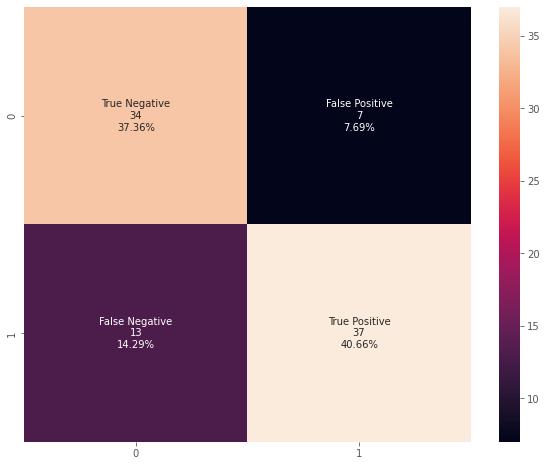

In [33]:
yhat2 = np.round(model.predict([X_test_crossed,X_test_cat,X_test_num]))

# create confusion matrix
cf_matrix = confusion_matrix(y_test, yhat2)

# create number of values in each group
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

# create percentages of each group
group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]

# create labels
group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(10,8))
sns.heatmap(cf_matrix, annot=labels, fmt='')

In [34]:
hist2Keys = list(history2.history.keys())
print(hist2Keys)

['loss', 'recall_1', 'auc_1', 'val_loss', 'val_recall_1', 'val_auc_1']


Text(0.5, 0, 'epochs')

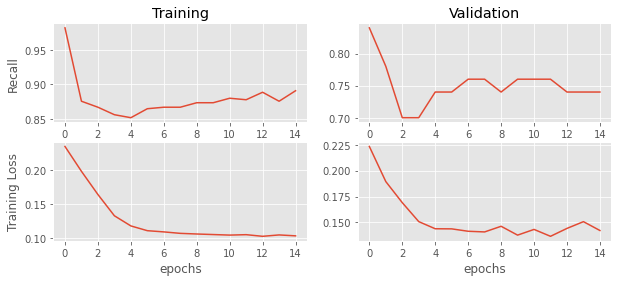

In [35]:
get_ipython().run_line_magic('matplotlib', 'inline')

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history2.history[hist2Keys[1]])

plt.ylabel('Recall')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history2.history[hist2Keys[4]])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history2.history[hist2Keys[0]])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history2.history[hist2Keys[3]])
plt.xlabel('epochs')

In [36]:
print(mt.classification_report(y_test,yhat2))
print("Model Accuracy: ",mt.accuracy_score(y_test,yhat2))

              precision    recall  f1-score   support

           0       0.72      0.83      0.77        41
           1       0.84      0.74      0.79        50

    accuracy                           0.78        91
   macro avg       0.78      0.78      0.78        91
weighted avg       0.79      0.78      0.78        91

Model Accuracy:  0.7802197802197802


### Third Combination

In [37]:
cross_columns = [['ChestPainType','RestingECG','ST_Slope'],
                ['Sex','ExerciseAngina']]

# cross each set of columns in the list above
cross_col_df_names = []
for cols_list in cross_columns:
    # encode as ints for the embedding
    enc = LabelEncoder()
    
    # 1. create crossed labels by join operation
    X_crossed_train = df_imputed[cols_list].apply(lambda x: '_'.join(x), axis=1)
   # X_crossed_test = df_test[cols_list].apply(lambda x: '_'.join(x), axis=1)
    
    # get a nice name for this new crossed column
    cross_col_name = '_'.join(cols_list)
    
    # 2. encode as integers
    enc.fit(np.hstack((X_crossed_train.to_numpy())))
    
    # 3. Save into dataframe with new name
    df_imputed[cross_col_name] = enc.transform(X_crossed_train)
    #df_test[cross_col_name] = enc.transform(X_crossed_test)
    
    # keep track of the new names of the crossed columns
    cross_col_df_names.append(cross_col_name) 

In [38]:
cross_X = df_imputed[cross_col_df_names].to_numpy()
# we want to predict the X and y data as follows:
cross_y = df_imputed['HeartDisease'].values # get the labels we want
iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(cross_X,cross_y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train_crossed = cross_X[train_indices]
    y_train_crossed = cross_y[train_indices]
    
    X_test_crossed = cross_X[test_indices]
    y_test_crossed = cross_y[test_indices]

In [39]:
crossed_outputs = []

# CROSSED DATA INPUT
input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
for idx,col in enumerate(cross_col_df_names):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = df_imputed[col].max()+1
    
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_crossed, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    crossed_outputs.append(x)
    

# now concatenate the outputs and add a fully connected layer
wide_branch = concatenate(crossed_outputs, name='wide_concat')

# reset this input branch
all_deep_branch_outputs = []

# CATEGORICAL DATA INPUT
input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
for idx,col in enumerate(categorical_headers_ints):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = df_imputed[col].max()+1
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_cat, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    all_deep_branch_outputs.append(x)
    
# NUMERIC DATA INPUT
# create dense input branch for numeric
input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
x_dense = Dense(units=22, activation='relu',name='num_1')(input_num)
    
all_deep_branch_outputs.append(x_dense)


# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    
# merge the deep and wide branch
final_branch = concatenate([wide_branch, deep_branch],
                           name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

model = Model(inputs=[input_crossed,input_cat,input_num], 
              outputs=final_branch)

In [40]:
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

model.summary()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 categorical_input (InputLayer)  [(None, 5)]         0           []                               
                                                                                                  
 tf.compat.v1.gather_26 (TFOpLa  (None,)             0           ['categorical_input[0][0]']      
 mbda)                                                                                            
                                                                                                  
 tf.compat.v1.gather_27 (TFOpLa  (None,)             0           ['categorical_input[0][0]']      
 mbda)                                    

In [41]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[Recall(),AUC(from_logits=True)])

In [42]:
history3 = model.fit([X_train_crossed,X_train_cat,X_train_num],
                    y_train, 
                    epochs=15, 
                    batch_size=32, 
                    verbose=1, 
                    validation_data = ([X_test_crossed,X_test_cat,X_test_num],y_test))

Epoch 1/15
26/26 [==============================] - 3s 20ms/step - loss: 0.2214 - recall_2: 0.8777 - auc_2: 0.8404 - val_loss: 0.2065 - val_recall_2: 0.6400 - val_auc_2: 0.8810
Epoch 2/15
26/26 [==============================] - 0s 5ms/step - loss: 0.1748 - recall_2: 0.8144 - auc_2: 0.8803 - val_loss: 0.1711 - val_recall_2: 0.7200 - val_auc_2: 0.8951
Epoch 3/15
26/26 [==============================] - 0s 5ms/step - loss: 0.1358 - recall_2: 0.8712 - auc_2: 0.9061 - val_loss: 0.1508 - val_recall_2: 0.7400 - val_auc_2: 0.8900
Epoch 4/15
26/26 [==============================] - 0s 5ms/step - loss: 0.1178 - recall_2: 0.8777 - auc_2: 0.9083 - val_loss: 0.1425 - val_recall_2: 0.8000 - val_auc_2: 0.8795
Epoch 5/15
26/26 [==============================] - 0s 5ms/step - loss: 0.1127 - recall_2: 0.8690 - auc_2: 0.9133 - val_loss: 0.1363 - val_recall_2: 0.8200 - val_auc_2: 0.8834
Epoch 6/15
26/26 [==============================] - 0s 6ms/step - loss: 0.1103 - recall_2: 0.8821 - auc_2: 0.9160 - val

3/3 [==============================] - 0s 3ms/step


<Axes: >

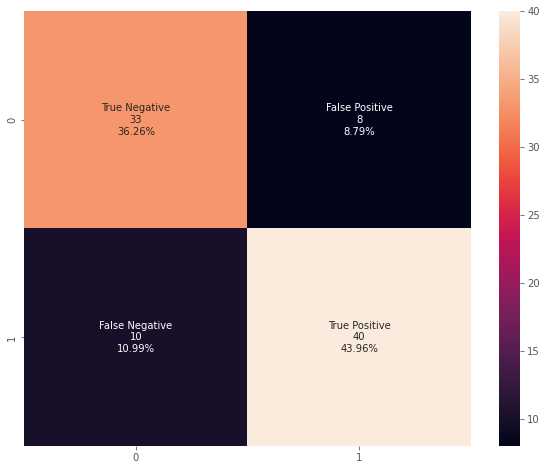

In [43]:
yhat3 = np.round(model.predict([X_test_crossed,X_test_cat,X_test_num]))

# create confusion matrix
cf_matrix = confusion_matrix(y_test, yhat3)

# create number of values in each group
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

# create percentages of each group
group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]

# create labels
group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(10,8))
sns.heatmap(cf_matrix, annot=labels, fmt='')

In [44]:
hist3Keys = list(history3.history.keys())
print(hist3Keys)

['loss', 'recall_2', 'auc_2', 'val_loss', 'val_recall_2', 'val_auc_2']


Text(0.5, 0, 'epochs')

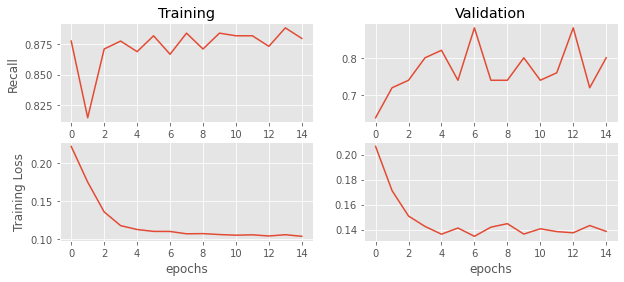

In [45]:
get_ipython().run_line_magic('matplotlib', 'inline')

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history3.history[hist3Keys[1]])

plt.ylabel('Recall')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history3.history[hist3Keys[4]])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history3.history[hist3Keys[0]])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history3.history[hist3Keys[3]])
plt.xlabel('epochs')

In [46]:
print(mt.classification_report(y_test,yhat3))
print("Model Accuracy: ",mt.accuracy_score(y_test,yhat3))

              precision    recall  f1-score   support

           0       0.77      0.80      0.79        41
           1       0.83      0.80      0.82        50

    accuracy                           0.80        91
   macro avg       0.80      0.80      0.80        91
weighted avg       0.80      0.80      0.80        91

Model Accuracy:  0.8021978021978022


### Model Performance Comparison of the First 3 Wide and Deep Networks

In [47]:
# print recall results of each model
print("Model 1 Recall: ",mt.recall_score(y_test,yhat1))
print("Model 2 Recall: ",mt.recall_score(y_test,yhat2))
print("Model 3 Recall: ",mt.recall_score(y_test,yhat3))

Model 1 Recall:  0.76
Model 2 Recall:  0.74
Model 3 Recall:  0.8


### Different Number of Layers

Next, we will create two wide and deep networks that have a different number of layers and compare their performance to each other.

### One Layer

In [48]:
crossed_outputs = []

# CROSSED DATA INPUT
input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
for idx,col in enumerate(cross_col_df_names):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = df_imputed[col].max()+1
    
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_crossed, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    crossed_outputs.append(x)
    

# now concatenate the outputs and add a fully connected layer
wide_branch = concatenate(crossed_outputs, name='wide_concat')

# reset this input branch
all_deep_branch_outputs = []

# CATEGORICAL DATA INPUT
input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
for idx,col in enumerate(categorical_headers_ints):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = df_imputed[col].max()+1
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_cat, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    all_deep_branch_outputs.append(x)
    
# NUMERIC DATA INPUT
# create dense input branch for numeric
input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
x_dense = Dense(units=22, activation='relu',name='num_1')(input_num)
    
all_deep_branch_outputs.append(x_dense)


# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
    
# merge the deep and wide branch
final_branch = concatenate([wide_branch, deep_branch],
                           name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

model = Model(inputs=[input_crossed,input_cat,input_num], 
              outputs=final_branch)

In [49]:
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [50]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[Recall(),AUC(from_logits=True)])

In [51]:
history4 = model.fit([X_train_crossed,X_train_cat,X_train_num],
                    y_train, 
                    epochs=15, 
                    batch_size=32, 
                    verbose=1, 
                    validation_data = ([X_test_crossed,X_test_cat,X_test_num],y_test))

Epoch 1/15
26/26 [==============================] - 2s 14ms/step - loss: 0.2403 - recall_3: 0.4236 - auc_3: 0.6813 - val_loss: 0.2211 - val_recall_3: 0.6800 - val_auc_3: 0.8534
Epoch 2/15
26/26 [==============================] - 0s 4ms/step - loss: 0.1962 - recall_3: 0.8035 - auc_3: 0.8697 - val_loss: 0.1856 - val_recall_3: 0.7000 - val_auc_3: 0.8849
Epoch 3/15
26/26 [==============================] - 0s 4ms/step - loss: 0.1564 - recall_3: 0.8624 - auc_3: 0.8905 - val_loss: 0.1557 - val_recall_3: 0.7400 - val_auc_3: 0.8880
Epoch 4/15
26/26 [==============================] - 0s 4ms/step - loss: 0.1313 - recall_3: 0.8603 - auc_3: 0.8954 - val_loss: 0.1432 - val_recall_3: 0.7200 - val_auc_3: 0.8956
Epoch 5/15
26/26 [==============================] - 0s 4ms/step - loss: 0.1204 - recall_3: 0.8712 - auc_3: 0.9018 - val_loss: 0.1375 - val_recall_3: 0.7200 - val_auc_3: 0.8944
Epoch 6/15
26/26 [==============================] - 0s 4ms/step - loss: 0.1146 - recall_3: 0.8428 - auc_3: 0.9128 - val

3/3 [==============================] - 0s 3ms/step


<Axes: >

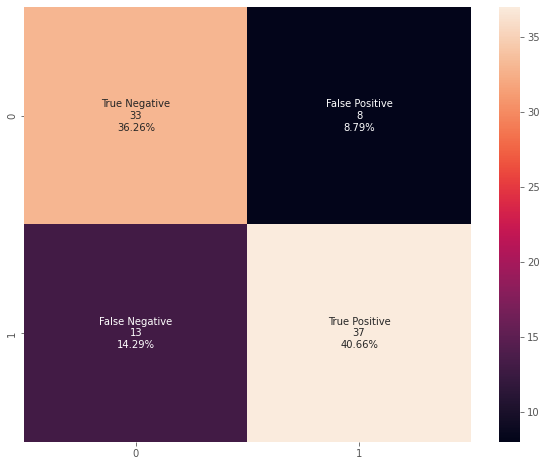

In [52]:
yhat4 = np.round(model.predict([X_test_crossed,X_test_cat,X_test_num]))

# create confusion matrix
cf_matrix = confusion_matrix(y_test, yhat4)

# create number of values in each group
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

# create percentages of each group
group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]

# create labels
group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(10,8))
sns.heatmap(cf_matrix, annot=labels, fmt='')


In [53]:
hist4Keys = list(history4.history.keys())
print(hist4Keys)

['loss', 'recall_3', 'auc_3', 'val_loss', 'val_recall_3', 'val_auc_3']


Text(0.5, 0, 'epochs')

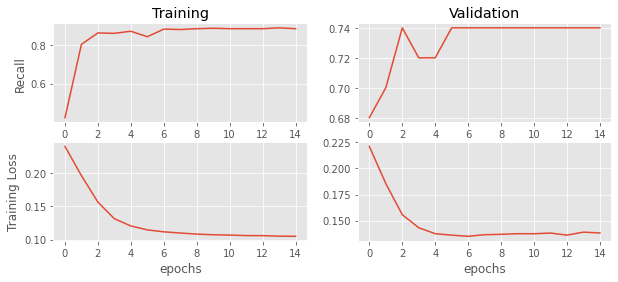

In [54]:
get_ipython().run_line_magic('matplotlib', 'inline')

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history4.history[hist4Keys[1]])

plt.ylabel('Recall')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history4.history[hist4Keys[4]])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history4.history[hist4Keys[0]])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history4.history[hist4Keys[3]])
plt.xlabel('epochs')

In [55]:
print(mt.classification_report(y_test,yhat4))
print("Model Accuracy: ",mt.accuracy_score(y_test,yhat4))

              precision    recall  f1-score   support

           0       0.72      0.80      0.76        41
           1       0.82      0.74      0.78        50

    accuracy                           0.77        91
   macro avg       0.77      0.77      0.77        91
weighted avg       0.77      0.77      0.77        91

Model Accuracy:  0.7692307692307693


### Four Layers

In [56]:
crossed_outputs = []

# CROSSED DATA INPUT
input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
for idx,col in enumerate(cross_col_df_names):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = df_imputed[col].max()+1
    
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_crossed, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    crossed_outputs.append(x)
    

# now concatenate the outputs and add a fully connected layer
wide_branch = concatenate(crossed_outputs, name='wide_concat')

# reset this input branch
all_deep_branch_outputs = []

# CATEGORICAL DATA INPUT
input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
for idx,col in enumerate(categorical_headers_ints):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = df_imputed[col].max()+1
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_cat, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    all_deep_branch_outputs.append(x)
    
# NUMERIC DATA INPUT
# create dense input branch for numeric
input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
x_dense = Dense(units=22, activation='relu',name='num_1')(input_num)
    
all_deep_branch_outputs.append(x_dense)


# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
deep_branch = Dense(units=5,activation='relu', name='deep4')(deep_branch)

# merge the deep and wide branch
final_branch = concatenate([wide_branch, deep_branch],
                           name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

model = Model(inputs=[input_crossed,input_cat,input_num], 
              outputs=final_branch)

In [57]:
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)


model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[Recall(),AUC(from_logits=True)])


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [58]:
history5 = model.fit([X_train_crossed,X_train_cat,X_train_num],
                    y_train, 
                    epochs=15, 
                    batch_size=32, 
                    verbose=1, 
                    validation_data = ([X_test_crossed,X_test_cat,X_test_num],y_test))

Epoch 1/15
26/26 [==============================] - 2s 15ms/step - loss: 0.2362 - recall_4: 0.9672 - auc_4: 0.7517 - val_loss: 0.2201 - val_recall_4: 0.9400 - val_auc_4: 0.8400
Epoch 2/15
26/26 [==============================] - 0s 4ms/step - loss: 0.2047 - recall_4: 0.9760 - auc_4: 0.8666 - val_loss: 0.1902 - val_recall_4: 0.9200 - val_auc_4: 0.9020
Epoch 3/15
26/26 [==============================] - 0s 4ms/step - loss: 0.1780 - recall_4: 0.9672 - auc_4: 0.8975 - val_loss: 0.1737 - val_recall_4: 0.9200 - val_auc_4: 0.8951
Epoch 4/15
26/26 [==============================] - 0s 4ms/step - loss: 0.1632 - recall_4: 0.9279 - auc_4: 0.9057 - val_loss: 0.1680 - val_recall_4: 0.8600 - val_auc_4: 0.8905
Epoch 5/15
26/26 [==============================] - 0s 4ms/step - loss: 0.1526 - recall_4: 0.8952 - auc_4: 0.9099 - val_loss: 0.1644 - val_recall_4: 0.8200 - val_auc_4: 0.8863
Epoch 6/15
26/26 [==============================] - 0s 4ms/step - loss: 0.1445 - recall_4: 0.8908 - auc_4: 0.9138 - val

3/3 [==============================] - 0s 0s/step


<Axes: >

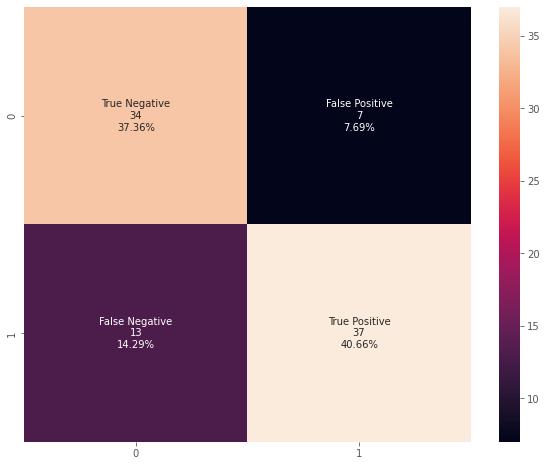

In [59]:
yhat5 = np.round(model.predict([X_test_crossed,X_test_cat,X_test_num]))

# create confusion matrix
cf_matrix = confusion_matrix(y_test, yhat5)

# create number of values in each group
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

# create percentages of each group
group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]

# create labels
group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(10,8))
sns.heatmap(cf_matrix, annot=labels, fmt='')

In [60]:
hist5Keys = list(history5.history.keys())
print(hist5Keys)

['loss', 'recall_4', 'auc_4', 'val_loss', 'val_recall_4', 'val_auc_4']


Text(0.5, 0, 'epochs')

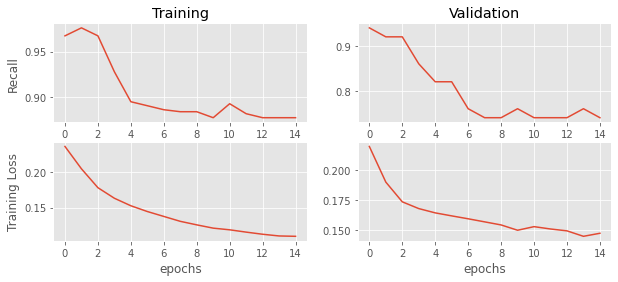

In [61]:
get_ipython().run_line_magic('matplotlib', 'inline')

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history5.history[hist5Keys[1]])

plt.ylabel('Recall')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history5.history[hist5Keys[4]])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history5.history[hist5Keys[0]])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history5.history[hist5Keys[3]])
plt.xlabel('epochs')

In [62]:
print(mt.classification_report(y_test,yhat5))
print("Model Accuracy: ",mt.accuracy_score(y_test,yhat5))

              precision    recall  f1-score   support

           0       0.72      0.83      0.77        41
           1       0.84      0.74      0.79        50

    accuracy                           0.78        91
   macro avg       0.78      0.78      0.78        91
weighted avg       0.79      0.78      0.78        91

Model Accuracy:  0.7802197802197802


### Model Performance Comparison

In [63]:
# print recall results of each model
print("Model 1 Recall: ",mt.recall_score(y_test,yhat1))
print("Model 2 Recall: ",mt.recall_score(y_test,yhat2))
print("Model 3 Recall: ",mt.recall_score(y_test,yhat3))
print("Model 4 Recall: ",mt.recall_score(y_test,yhat4))
print("Model 5 Recall: ",mt.recall_score(y_test,yhat5))

Model 1 Recall:  0.76
Model 2 Recall:  0.74
Model 3 Recall:  0.8
Model 4 Recall:  0.74
Model 5 Recall:  0.74


### Deep Network vs Wide and Deep Network

Next, we will create a deep network (without a wide branch) and compare its results to a wide and deep network.

In [ ]:
# we need to create separate lists for each branch
crossed_outputs = []

# CROSSED DATA INPUT
input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='deep_inputs')
for idx,col in enumerate(cross_col_df_names):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = df_imputed[col].max()+1
    
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_crossed, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    crossed_outputs.append(x)
    

# now concatenate the outputs and add a fully connected layer
#wide_branch = concatenate(crossed_outputs, name='wide_concat')

# reset this input branch
all_deep_branch_outputs = []

# CATEGORICAL DATA INPUT
input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
for idx,col in enumerate(categorical_headers_ints):
    
    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = df_imputed[col].max()+1
    
    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_cat, idx, axis=1)
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(x)
    
    # save these outputs to concatenate later
    all_deep_branch_outputs.append(x)
    
# NUMERIC DATA INPUT
# create dense input branch for numeric
input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
x_dense = Dense(units=22, activation='relu',name='num_1')(input_num)
    
all_deep_branch_outputs.append(x_dense)


# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
deep_branch = Dense(units=5,activation='relu', name='deep4')(deep_branch)    

# merge the deep and wide branch
final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(deep_branch)

model = Model(inputs=[input_crossed,input_cat,input_num], 
              outputs=final_branch)

In [ ]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[Recall(),AUC(from_logits=True)])

In [ ]:
history6 = model.fit([X_train_crossed,X_train_cat,X_train_num],
                    y_train, 
                    epochs=15, 
                    batch_size=32, 
                    verbose=1, 
                    validation_data = ([X_test_crossed,X_test_cat,X_test_num],y_test))

In [ ]:
yhat6 = np.round(model.predict([X_test_crossed,X_test_cat,X_test_num]))

# create confusion matrix
cf_matrix = confusion_matrix(y_test, yhat6)

# create number of values in each group
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

# create percentages of each group
group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]

# create labels
group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(10,8))
sns.heatmap(cf_matrix, annot=labels, fmt='')

In [ ]:
hist6Keys = list(history6.history.keys())
print(hist6Keys)

In [ ]:
get_ipython().run_line_magic('matplotlib', 'inline')

plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.plot(history6.history[hist6Keys[1]])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history6.history[hist6Keys[3]])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history6.history[hist6Keys[0]])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history6.history[hist6Keys[2]])
plt.xlabel('epochs')

print(mt.classification_report(y_test,yhat6))
print("Model Accuracy: ",mt.accuracy_score(y_test,yhat6))

In [ ]:
print("Model Accuracy 1: ",mt.accuracy_score(y_test,yhat1))
print("Model Accuracy 2: ",mt.accuracy_score(y_test,yhat2))
print("Model Accuracy 3: ",mt.accuracy_score(y_test,yhat3))
print()
print("Model Accuracy 4: ",mt.accuracy_score(y_test,yhat4))
print("Model Accuracy 5: ",mt.accuracy_score(y_test,yhat5))
print()
print("Model Accuracy 6: ",mt.accuracy_score(y_test,yhat6))

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn import metrics as mt

clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)

clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)

print(mt.accuracy_score(y_test,y_hat))

In [ ]:
get_ipython().run_cell_magic('time', '', "from sklearn.linear_model import LogisticRegression\nfrom sklearn.metrics import accuracy_score\n\nlr_sk = LogisticRegression(max_iter = 100) # all params default\n# note that sklearn is optimized for using the liblinear library with logistic regression\n# ...and its faster than our implementation here\n\nlr_sk.fit(X_train,y_train) # no need to add bias term, sklearn does it internally!!\n#print(lr_sk.coef_)\ny_hat1 = lr_sk.predict(X_test)\nprint('Accuracy of: ',accuracy_score(y_test,y_hat1))\n#plot_decision_boundaries(lr_sk,X_train,y_train, title = 'Logistic regression from sklrearn')\n")

## Graduate Analysis

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)
pca.fit(X) # fit data and then transform it
X_pca = pca.transform(X)

In [ ]:
cmap = sns.set(style="darkgrid") 
# this function definition just formats the weights into readable strings
# you can skip it without loss of generality to the Data Science content
def get_feature_names_from_weights(weights, names):
    tmp_array = []
    for comp in weights:
        tmp_string = ''
        for fidx,f in enumerate(names):
            if fidx>0 and comp[fidx]>=0:
                tmp_string+='+'
            tmp_string += '%.2f*%s ' % (comp[fidx],f[:-5])
        tmp_array.append(tmp_string)
    return tmp_array
  
plt.style.use('default')
pca_weight_strings = get_feature_names_from_weights(pca.components_, feature_columns) 

# create some pandas dataframes from the transformed outputs
df_pca = pd.DataFrame(X_pca,columns=[pca_weight_strings])

from matplotlib.pyplot import scatter

# scatter plot the output, with the names created from the weights
plt.figure(figsize=(15,15))
plt.xlabel(pca_weight_strings[0]) 
plt.ylabel(pca_weight_strings[1])
ax = scatter(X_pca[:,0], X_pca[:,1], c=y, s=(y+2)*10, cmap=cmap)